In [1]:
import numpy as np
import seaborn as sns
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#Others
import time
import copy

In [10]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Download and load the training data
train_data = datasets.MNIST('data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('data/', download=True, train=False, transform=transform)

# Load the datasets
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

# Dataset sizes
class_names = train_data.classes
dataset_sizes = {'train':len(train_data), 'val':len(test_data)}
dataloaders  = {'train':trainloader, 'val':testloader}

dataiter = iter(trainloader)  # Create an iterator from the DataLoader
images, labels = next(dataiter)  # Use the next() function to get the next batch of images and labels

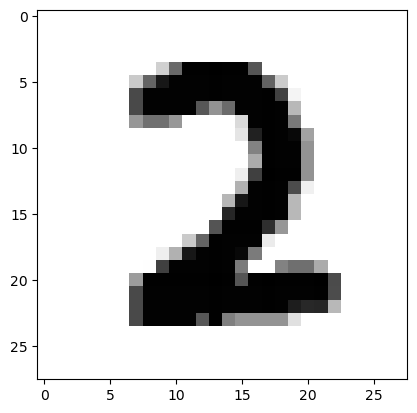

In [11]:
plt.imshow(images[10].numpy().squeeze(), cmap='gray_r');

In [12]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=(2,2)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=(2,2)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
        )
    
    
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=(2,2)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=(2,2)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
        )
        
          

        self.fcs = nn.Sequential(
            nn.Linear(2304, 1152),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1152, 576),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(576, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x
   

In [13]:
model = Net()
model

Net(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

if torch.cuda.is_available():
    model = model.to(device)
    criterion = criterion.to(device)

In [15]:
def train_model(model, criterion, optimizer, scheduler, dataset_sizes, dataloaders, num_epochs):
    since = time.time()  # 开始计时，追踪训练时间

    best_model_wts = copy.deepcopy(model.state_dict())  # 深拷贝模型的权重，用于保存最好的模型
    best_acc = 0.0  # 初始化最好的准确率
    
    # Lists to store accuracy values for plotting
    train_acc_history = []
    val_acc_history = []
    best_preds = None
    best_labels = None  # 用来保存最佳模型对应的预测和真实标签
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每一轮有训练和验证两个阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为验证模式

            running_loss = 0.0  # 初始化当前阶段的损失
            running_corrects = 0  # 初始化当前阶段的正确预测数
            all_preds = []
            all_labels = []
            
            # 遍历数据集
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # 将输入数据移到设备（CPU或GPU）
                labels = labels.to(device)  # 将标签移到设备

                # 清空参数梯度（用于优化）
                optimizer.zero_grad()

                # 前向传播：如果是训练阶段，计算梯度，否则不计算梯度
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # 获取模型输出
                    _, preds = torch.max(outputs, 1)  # 获取预测类别
                    loss = criterion(outputs, labels)  # 计算损失

                    # 只有在训练阶段，才进行反向传播和优化
                    if phase == 'train':
                        loss.backward()  # 反向传播，计算梯度
                        optimizer.step()  # 更新权重

                # 更新运行中的损失和正确预测数量
                running_loss += loss.item() * inputs.size(0)  # 累加损失
                running_corrects += torch.sum(preds == labels.data)  # 累加正确预测数

                # 收集所有预测和真实标签
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
 
            
            # 如果是训练阶段，更新学习率
            if phase == 'train':
                scheduler.step()

            # 计算当前轮次的损失和准确率
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Save the accuracy for plotting
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())
                
            # 如果是验证阶段，且当前准确率最好，保存当前模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc  # 更新最好的准确率
                best_model_wts = copy.deepcopy(model.state_dict())  # 保存最好的模型权重
                best_preds = all_preds
                best_labels = all_labels
        print()  # 每个 epoch 后打印一个空行

    # 计算总的训练时间
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 加载最好的模型权重
    model.load_state_dict(best_model_wts)
    
    def plot_confusion_matrix(y_true, y_pred, classes):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title('Confusion Matrix (Best Model)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()   
        
    plot_confusion_matrix(best_labels, best_preds, classes=dataloaders['train'].dataset.classes)
    
    def plot_accuracy(train_acc_history, val_acc_history):
        # Create a plot for accuracy over epochs
        plt.figure(figsize=(10, 6))
        plt.plot(train_acc_history, label='Train Accuracy', color='blue')
        plt.plot(val_acc_history, label='Validation Accuracy', color='orange')
        plt.title('Training and Validation Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
    
    plot_accuracy(train_acc_history, val_acc_history)
        
    return model  # 返回最好的模型
    
    

Epoch 0/24
----------
train Loss: 0.1734 Acc: 0.9475
val Loss: 0.0384 Acc: 0.9886

Epoch 1/24
----------
train Loss: 0.0646 Acc: 0.9823
val Loss: 0.0321 Acc: 0.9912

Epoch 2/24
----------
train Loss: 0.0492 Acc: 0.9871
val Loss: 0.0279 Acc: 0.9920

Epoch 3/24
----------
train Loss: 0.0426 Acc: 0.9887
val Loss: 0.0360 Acc: 0.9899

Epoch 4/24
----------
train Loss: 0.0372 Acc: 0.9903
val Loss: 0.0317 Acc: 0.9910

Epoch 5/24
----------
train Loss: 0.0171 Acc: 0.9953
val Loss: 0.0164 Acc: 0.9956

Epoch 6/24
----------
train Loss: 0.0124 Acc: 0.9970
val Loss: 0.0168 Acc: 0.9960

Epoch 7/24
----------
train Loss: 0.0108 Acc: 0.9972
val Loss: 0.0152 Acc: 0.9965

Epoch 8/24
----------
train Loss: 0.0090 Acc: 0.9975
val Loss: 0.0167 Acc: 0.9961

Epoch 9/24
----------
train Loss: 0.0078 Acc: 0.9980
val Loss: 0.0174 Acc: 0.9956

Epoch 10/24
----------
train Loss: 0.0061 Acc: 0.9983
val Loss: 0.0166 Acc: 0.9957

Epoch 11/24
----------
train Loss: 0.0056 Acc: 0.9985
val Loss: 0.0166 Acc: 0.9958

Ep

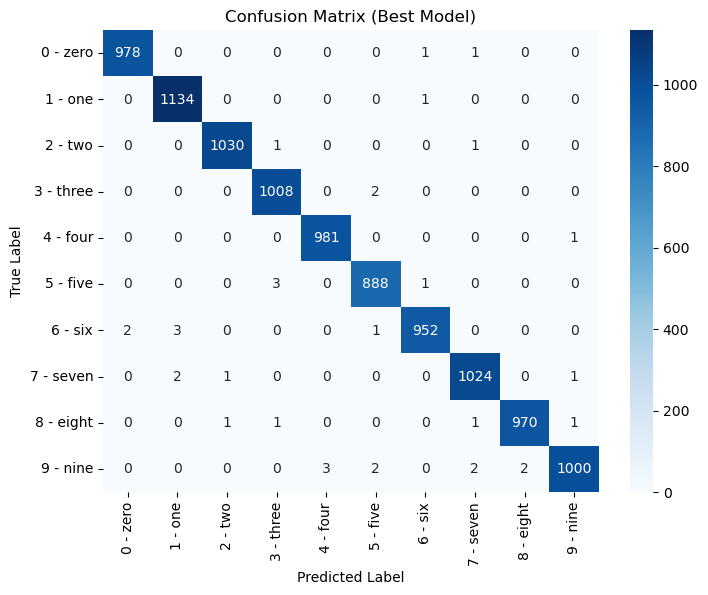

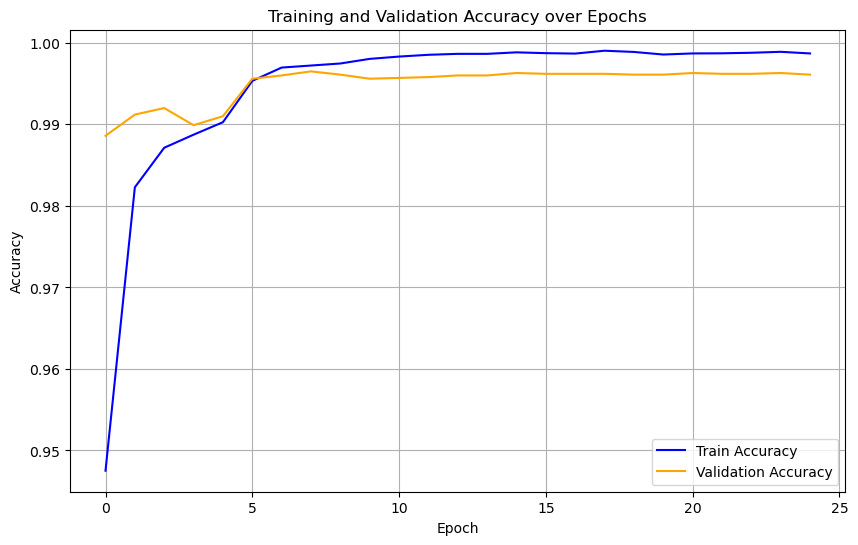

In [16]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,dataset_sizes,dataloaders,num_epochs=25)

In [22]:
def imshow(inp, ax, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().squeeze()  # Convert to numpy and remove singleton dimensions
    ax.imshow(inp, cmap='gray_r')  # Display image with gray colormap
    ax.axis('off')  # Hide axes
    if title is not None:
        ax.set_title(title)  # Set the title above the image

In [34]:
import torch.nn.functional as F
def visualize_correct_predictions(model,num_images):
    was_training = model.training
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    
    correct_images = []  # List to store correct predictions for visualization
    correct_labels = []
    correct_preds = []
    confidences = []  # List to store confidence values
    
    with torch.no_grad():  # No need to track gradients
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Apply Softmax to get probabilities
            probs = F.softmax(outputs, dim=1)  # Shape: [batch_size, num_classes]

            correct_indices = (preds == labels)  # Boolean mask for correct predictions

            for j in range(inputs.size()[0]):
                if correct_indices[j]:
                    correct_images.append(inputs.cpu().data[j])
                    correct_labels.append(labels[j].cpu().item())
                    correct_preds.append(preds[j].cpu().item())
                    confidences.append(probs[j, preds[j]].cpu().item())  # Get confidence for the predicted class
                    images_so_far += 1

                # Stop if we have visualized 'num_images' correct predictions
                if images_so_far == num_images:
                    break
            if images_so_far == num_images:
                break

    # Visualize the correct predictions
    plt.figure(figsize=(12, 6))

    # Calculate grid size based on number of images to show
    num_cols = 4  # You can adjust this based on your preference
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows based on num_images

    for i in range(images_so_far):
        ax = plt.subplot(num_rows, num_cols, i + 1)  # Adjusting to dynamic rows and columns
        title = f'True: {class_names[correct_labels[i]]}\nPred: {class_names[correct_preds[i]]}\nConf: {confidences[i]:.2f}'
        imshow(correct_images[i], ax, title)

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()  # Show the plot

    model.train(mode=was_training)  # Restore model to original mode

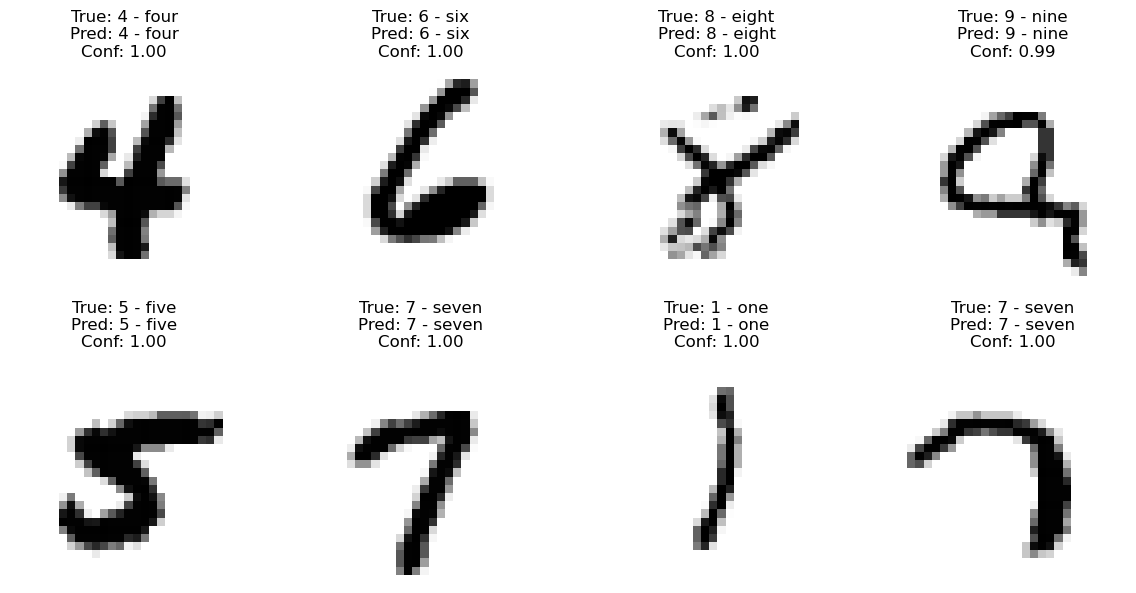

In [38]:
visualize_correct_predictions(model, num_images=8)

In [39]:
def visualize_wrong_predictions(model, num_images):
    was_training = model.training
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    
    wrong_images = []  # List to store wrong predictions for visualization
    wrong_labels = []
    wrong_preds = []
    confidences = []  # List to store confidence values
    
    with torch.no_grad():  # No need to track gradients
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Apply Softmax to get probabilities
            probs = F.softmax(outputs, dim=1)  # Shape: [batch_size, num_classes]
            
            wrong_indices = (preds != labels)  # Boolean mask for wrong predictions

            for j in range(inputs.size()[0]):
                if wrong_indices[j]:
                    wrong_images.append(inputs.cpu().data[j])
                    wrong_labels.append(labels[j].cpu().item())
                    wrong_preds.append(preds[j].cpu().item())
                    confidences.append(probs[j, preds[j]].cpu().item())  # Get confidence for the predicted class
                    images_so_far += 1

                # Stop if we have visualized 'num_images' wrong predictions
                if images_so_far == num_images:
                    break
            if images_so_far == num_images:
                break

    # Visualize the wrong predictions
    plt.figure(figsize=(12, 6))

   # Calculate grid size based on number of images to show
    num_cols = 4  # You can adjust this based on your preference
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows based on num_images

    for i in range(images_so_far):
        ax = plt.subplot(num_rows, num_cols, i + 1)  # Adjusting to dynamic rows and columns
        title = f'True: {class_names[wrong_labels[i]]}\nPred: {class_names[wrong_preds[i]]}\nConf: {confidences[i]:.2f}'
        imshow(wrong_images[i], ax, title)

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()  # Show the plot

    model.train(mode=was_training)  # Restore model to original mode

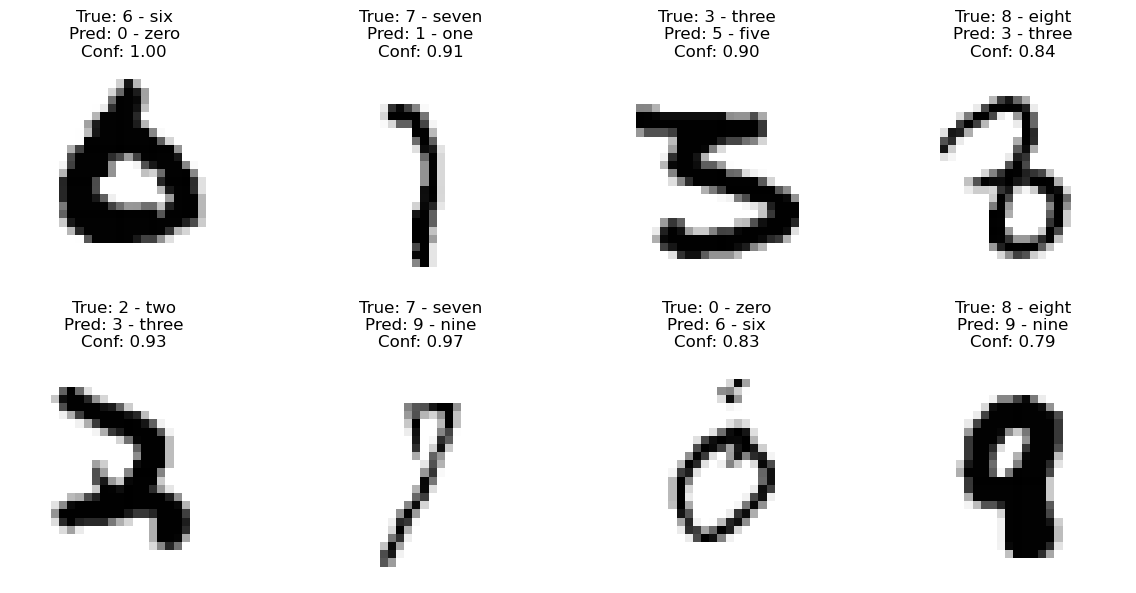

In [40]:
visualize_wrong_predictions(model, num_images=8)